#01-EXPLORACION

In [1]:
!pip install opendatasets
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.8 MB/s eta 0:00:00


In [2]:
import opendatasets as od
import os
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib
import spacy
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer

In [3]:
# Importamos de kaggle el set
dataset_link="https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis" #Link donde se ubica el set de datos.
od.download(dataset_link)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: martinerramuspe
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis


100%|██████████| 1.99M/1.99M [00:00<00:00, 134MB/s]

In [4]:
os.chdir("twitter-entity-sentiment-analysis") # nombre del directorio
os.listdir() # lista de archivos del directorio

['twitter_validation.csv', 'twitter_training.csv']

In [5]:
# Configuraciones estructural de set importado.
columns = ['id','country','Label','Text']
archivo="twitter_training.csv"
archivo2="twitter_validation.csv"
df1=pd.read_csv(archivo,names=columns) # Importamos datos.
df2=pd.read_csv(archivo2,names=columns) # Importamos datos.
print(f"El set train tiene la siguiente dimension:{df1.shape}")
print(f"El set validacion tiene la siguiente dimension:{df2.shape}")
df = pd.concat([df1, df2], ignore_index=True)
print(f"El set concatenado tiene la siguiente dimension:{df.shape}")

El set train tiene la siguiente dimension:(74682, 4)
El set validacion tiene la siguiente dimension:(1000, 4)
El set concatenado tiene la siguiente dimension:(75682, 4)


In [6]:
df.head()

,id,country,Label,Text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75682 entries, 0 to 75681
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       75682 non-null  int64 
 1   country  75682 non-null  object
 2   Label    75682 non-null  object
 3   Text     74996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


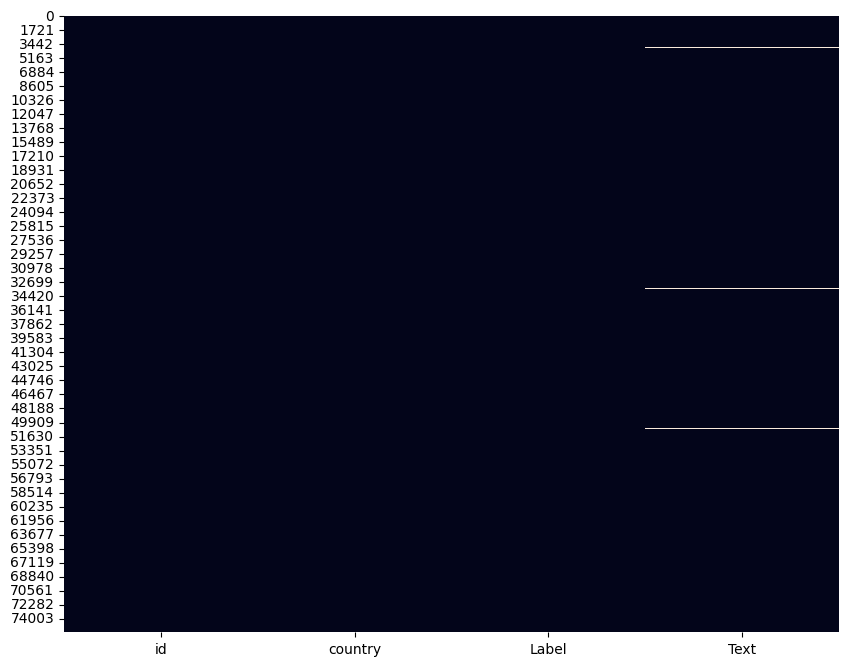

In [8]:
# Verificamos de forma grafica,la presencia de datos nulos
plt.figure(figsize=(10, 8))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [9]:
# LAS ETIQUETAS DE LA VARIABLE TARGET, ESTAN BALANCEADAS?
conteo = df['Label'].value_counts()
fig = px.pie(names=conteo.index, values=conteo.values, title='Distribución de Etiquetas')
fig.show()

In [10]:
# QUE JUEGO TIENE MAS COMENTARIOS?
conteo = df["country"].value_counts().reset_index()
conteo.columns = ['country', 'count']
# Crear el gráfico de barras horizontales con Plotly Express
fig = px.bar(conteo, y='country', x='count', orientation='h',
             height=1000)  # Ajustar la altura del gráfico
fig.show()

In [13]:
df['country'].value_counts()

country
TomClancysRainbowSix                 2435
LeagueOfLegends                      2431
MaddenNFL                            2429
Microsoft                            2428
CallOfDuty                           2425
Verizon                              2414
ApexLegends                          2412
Facebook                             2403
CallOfDutyBlackopsColdWar            2403
WorldOfCraft                         2394
Dota2                                2391
FIFA                                 2378
NBA2K                                2373
Battlefield                          2372
TomClancysGhostRecon                 2368
johnson&johnson                      2367
Overwatch                            2366
Xbox(Xseries)                        2360
Amazon                               2350
PlayStation5(PS5)                    2343
GrandTheftAuto(GTA)                  2339
CS-GO                                2336
Cyberpunk2077                        2334
Nvidia                    

In [ ]:
# QUE JUEGO TIENE MAS COMENTARIOS POSITIVOS?

df1 = df.groupby(['country', 'Label']).size().reset_index(name='count')
# Filtrar solo las filas donde 'Label' sea 'Positive'
df1_positive = df1[df1['Label'] == 'Positive']
# Ordenar la columna "count" de forma decreciente
df1_positive = df1_positive.sort_values(by='count', ascending=True)
# Impresion
print(df1_positive.head(4))

# Creacion de grafico de barras con px
fig = px.bar(df1_positive, y='country', x='count', orientation='h', title='Top comentarios positivo',
             color='count')
fig.update_traces(marker=dict(colorscale='Viridis'), selector=dict(type='bar'))
fig.update_layout(height=900)
fig.show()

             country     Label  count
47          Facebook  Positive    177
127  johnson&johnson  Positive    274
3             Amazon  Positive    319
55            Google  Positive    363


In [ ]:
# QUE JUEGO TIENE MAS COMENTARIOS NEGATIVO?

df2 = df.groupby(['country', 'Label']).size().reset_index(name='count')
# Filtrar solo las filas donde 'Label' sea 'Positive'
df1_negative = df1[df1['Label'] == 'Negative']
# Ordenar la columna "count" de forma decreciente
df1_negative = df1_negative.sort_values(by='count', ascending=True)
# Impresion
print(df1_negative.head(4))


# Creacion de grafico de barras con px
fig = px.bar(df1_negative, y='country', x='count', orientation='h', title='Top comentarios negativos',
             color='count')
fig.update_traces(marker=dict(colorscale='Plasma'), selector=dict(type='bar'))
fig.update_layout(height=900)
fig.show()

                    country     Label  count
101  RedDeadRedemption(RDR)  Negative    311
117            WorldOfCraft  Negative    343
21                    CS-GO  Negative    350
9            AssassinsCreed  Negative    382


In [ ]:
# QUE JUEGO TIENE MAS COMENTARIOS NEUTROS ?

df2 = df.groupby(['country', 'Label']).size().reset_index(name='count')
# Filtrar solo las filas donde 'Label' sea 'Positive'
df1_neutro = df1[df1['Label'] == 'Neutral']
# Ordenar la columna "count" de forma decreciente
df1_neutro = df1_neutro.sort_values(by='count', ascending=True)
# Impresion
print(df1_neutro.head(4))


# Creacion de grafico de barras con px
fig = px.bar(df1_neutro, y='country', x='count', orientation='h', title='Top comentarios neutrales',
             color='count')
fig.update_traces(marker=dict(colorscale='Plasma'), selector=dict(type='bar'))
fig.update_layout(height=900)
# Mostrar el gráfico
fig.show()

           country    Label  count
42            FIFA  Neutral    106
10  AssassinsCreed  Neutral    160
50        Fortnite  Neutral    169
74       MaddenNFL  Neutral    206


In [ ]:
# Determinamos la cantidad de palabras que tiene cada frase.
df = df.dropna(subset=['Text'])# Eliminamos las filas con  NaN.
# Aplicamos funcion de conteo.
df['word_count'] = df['Text'].apply(lambda x: len(x.split()))

In [ ]:
# QUE FORMA TIENE LA DISTRIBUCION DE "word_count" ?
fig = px.histogram(df, x='word_count', title='Histograma de Conteo de Palabras por Frase')
fig.show()

In [ ]:
# HAY CATEGORIAS QUE TENGAN UNA  DISTRIBUCION PARTICULAR?
fig = px.box(df, x='word_count', y='Label', orientation='h', color='Label',
             title='Box-plot por categoria')
fig.show()

# 02-PREPROCESAMIENTO

In [ ]:
# 01 Eliminamos  fila donde aparezca por lo menos 1 dato NaN
df.dropna(inplace=True)

In [ ]:
# 02 Carga y aplicacion de paquete de procesamientode texto, usando spacy.
#Cargamos paquete preprocesador de lenguaje
nlp = spacy.load("en_core_web_sm")
# Funcion a desarrolla varios procesos en el texto:
# -tokenizar
# -Eliminación de palabras de parada y lematización
# -Filtrado de tokens
# -Reconstrucción del texto preprocesado

def preprocess(text):

    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)

    return " ".join(filtered_tokens)

# Aplicamos funcion
df["Preprocessed_Text"]=df["Text"].apply(preprocess)

In [ ]:
# 03 Transformamos en numeros, las etiquetas de la variable target "Label"
# Positive: 3
# Irrelevant: 0
# Neutral: 2
# Negative: 1
le_model = LabelEncoder()
df['Label'] = le_model.fit_transform(df['Label'])

In [ ]:
# 04 Filtramos en variables predictoras y variable target de interes.
X= df[["country", "Preprocessed_Text"]]
y= df['Label']

In [ ]:
# 05 Vectorizamos texto de la variable "Text"

# Combinar las columnas de texto en una sola columna
X['Combined_Text'] = X['Preprocessed_Text'] + ' ' + X['country']

# Crear el objeto TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

# Transformar las columnas combinadas en variables predictoras numéricas
X = vectorizer.fit_transform(X['Combined_Text'])

<ipython-input-21-3f25002f141a>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



explicacion de max_df = 0.7:

En el caso de un DataFrame donde cada fila representa un comentario y la columna "comment" contiene el texto de esos comentarios, la frecuencia del documento se calcularía sobre la base de cuántos comentarios (filas) contienen la palabra "hermoso".

Si la palabra "hermoso" aparece en 80 de las 100 filas, esto significa que tiene una frecuencia del documento del 80%. Si se establece max_df=0.7, cualquier palabra que aparezca en más del 70% de los comentarios sería ignorada durante la vectorización TF-IDF.

En este ejemplo, "hermoso" se ignoraría durante el proceso de vectorización TF-IDF si se establece max_df=0.7, ya que su frecuencia del documento es del 80%, lo que supera el límite del 70%.

In [ ]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=df['Label'])#stratify es para respete el balance de etiquetas cuando se realiza el split.

In [ ]:
print("Dimension de X_train:", X_train.shape)
print("Dimension de X_test:", X_test.shape)

Dimension de X_train: (59996, 28400)
Dimension de X_test: (15000, 28400)


# 03-SELECCION DE MODELO


In [ ]:
# MODELO: Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Medir el tiempo de inicio
start_time = time.time()

# Entrenar el modelo en los datos de entrenamiento
rf_model.fit(X_train, y_train)

# Medir el tiempo de finalización
end_time = time.time()

# Calcular la duración del entrenamiento
time_rf = end_time - start_time
print("Training Time:", time_rf, "seconds")

# Predecir en los datos de prueba
y_pred_rf = rf_model.predict(X_test)

# Calcular la precisión del modelo Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy of Random Forest:", accuracy_rf)

Training Time: 329.365683555603 seconds
Accuracy of Random Forest: 0.9410666666666667


In [ ]:
# MODELO: KNN
knn_model = KNeighborsClassifier()

# Medir el tiempo de inicio
start_time = time.time()

# Entrenar el modelo en los datos de entrenamiento
knn_model.fit(X_train, y_train)

# Medir el tiempo de finalización
end_time = time.time()

# Calcular la duración del entrenamiento
time_knn = end_time - start_time
print("Training Time:", time_knn, "seconds")

# Predecir en los datos de prueba
y_pred_knn = knn_model.predict(X_test)

# Calcular la precisión del modelo KNN
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("Accuracy of KNN:", accuracy_knn)

Training Time: 0.012732744216918945 seconds
Accuracy of KNN: 0.9181333333333334


In [ ]:
# MODELO: PassiveAggressive
clf = PassiveAggressiveClassifier(C=1.0, loss='hinge', tol=1e-3, max_iter=500, fit_intercept=True, random_state=42)

# Medir el tiempo de inicio
start_time = time.time()

# Entrenar el modelo
clf.fit(X_train, y_train)

# Medir el tiempo de finalización
end_time = time.time()

# Realizar predicciones en el conjunto de prueba
y_pred = clf.predict(X_test)

# Calcular la duración del entrenamiento
time_p = end_time - start_time
print("Training Time:", time_p, "seconds")

# Calcular la precisión del modelo
accuracy_p = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_p)

Training Time: 1.1631851196289062 seconds
Accuracy: 0.8542666666666666


In [ ]:
# MODELO: CatBoost
catboost_model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, loss_function='MultiClass', random_state=42)

# Medir el tiempo de inicio
start_time = time.time()

# Entrenar el modelo
catboost_model.fit(X_train, y_train, verbose=False)

# Medir el tiempo de finalización
end_time = time.time()

# Calcular la duración del entrenamiento
time_cat = end_time - start_time
print("Training Time:", time_cat, "seconds")

# Realizar predicciones en el conjunto de prueba
y_pred_catboost = catboost_model.predict(X_test)

# Calcular la precisión del modelo
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
print("Accuracy of CatBoost:", accuracy_catboost)


Training Time: 166.98195028305054 seconds
Accuracy of CatBoost: 0.535


In [ ]:
# COMPARAMOS PRESICIONES Y TIEMPOS DE ENTRENAMIENTO.
data = {'Modelo': ['Random Forest', 'KNN','Passive','CatBoost'],
        "Presicion":[accuracy_rf,accuracy_knn,accuracy_p, accuracy_catboost],
        'Train_time': [time_rf, time_knn, time_p, time_cat ]}
df0 = pd.DataFrame(data)

# Crear el gráfico con Plotly Express y ajustar el ancho de las barras y el color
fig = px.bar(df0, x='Modelo', y='Presicion', text='Presicion', color='Modelo')
# datos en  grafica
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
# Añadir un título al gráfico
fig.update_layout(title='PRESICION')
# Mostrar el gráfico
fig.show()

# Crear el gráfico con Plotly Express y ajustar el ancho de las barras y el color
fig = px.bar(df0, x='Modelo', y='Train_time', text='Train_time', color='Modelo')
# datos en  grafica
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
# Añadir un título al gráfico
fig.update_layout(title='TIME')
# Mostrar el gráfico
fig.show()

# 04-ANALISIS MATRIZ DE CONFUSION

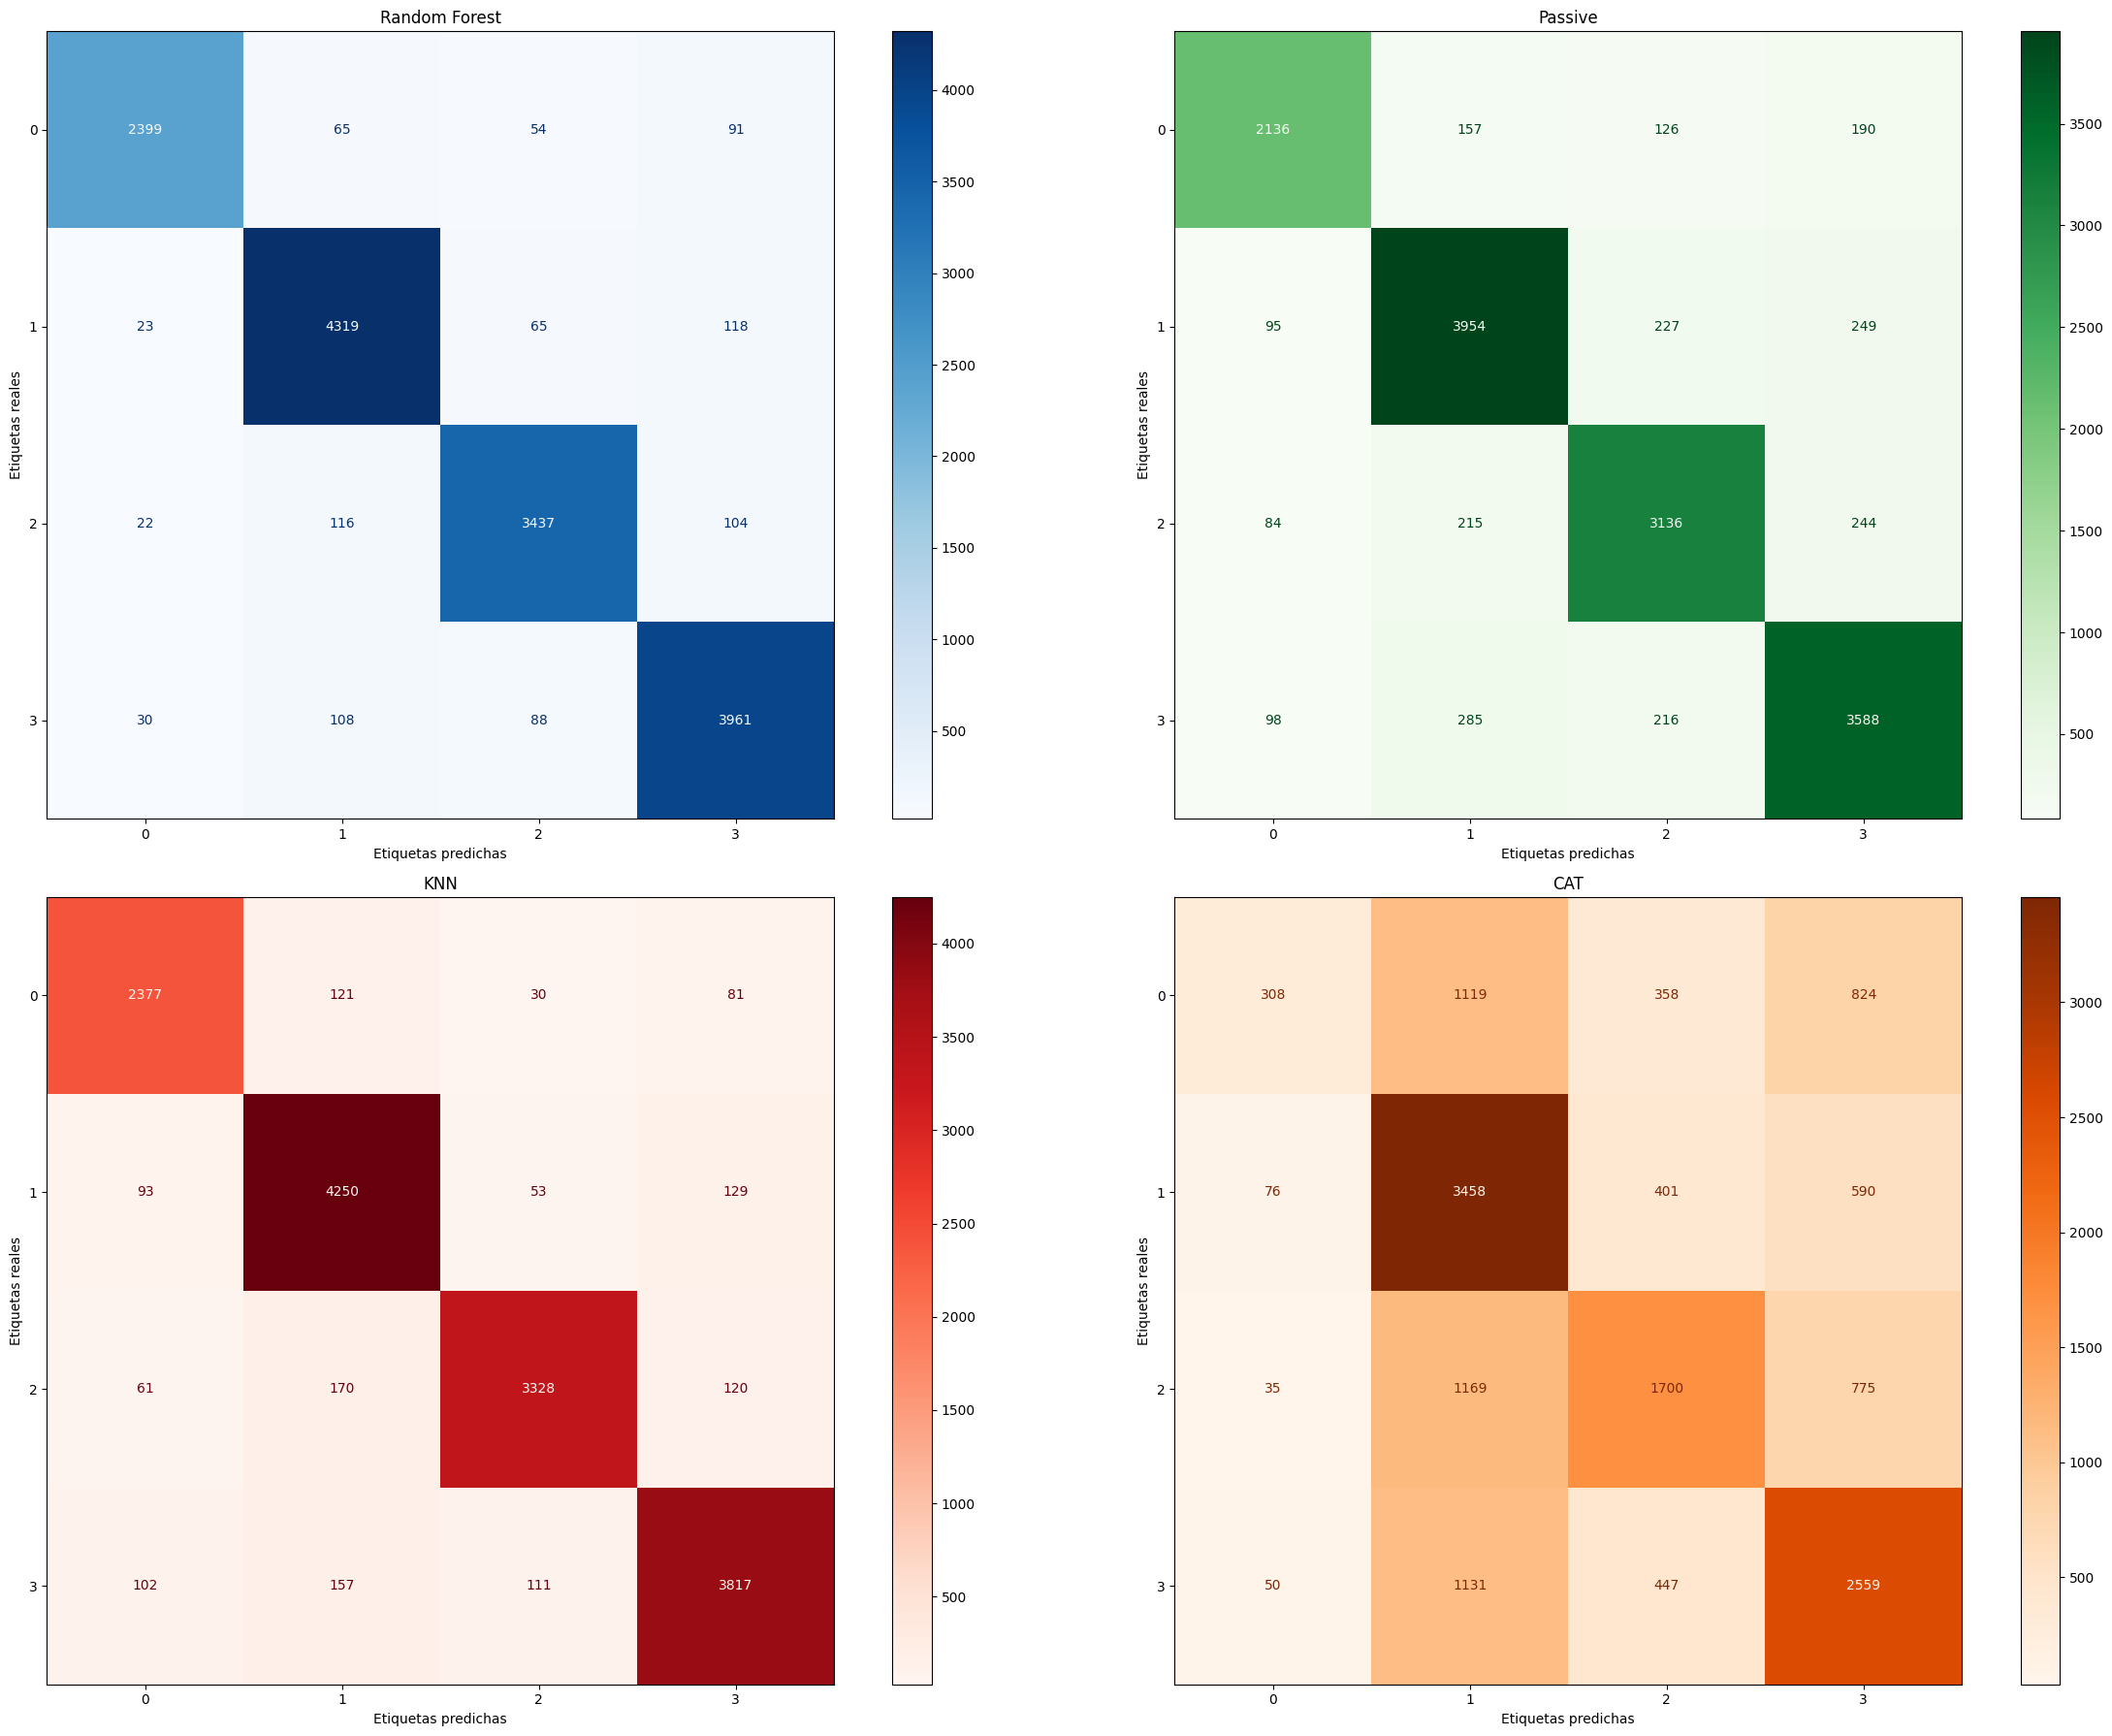

In [ ]:
# Definir los modelos y sus etiquetas
modelos = [rf_model, clf, knn_model, catboost_model]
nombres_modelos = ['Random Forest', 'Passive', 'KNN', 'CAT']
colores = ['Blues', 'Greens', 'Reds', 'Oranges']  # Esquema de colores diferente para cada gráfico

# Configurar el tamaño de la figura
plt.figure(figsize=(24, 18))

# Iterar sobre los modelos
for i, (modelo, nombre_modelo, color) in enumerate(zip(modelos, nombres_modelos, colores), start=1):
    # Obtener las predicciones para el conjunto de pruebas
    y_pred = modelo.predict(X_test)

    # Calcular la matriz de confusión
    matriz_confusion = confusion_matrix(y_test, y_pred)

    # Crear el objeto ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion)

    # Subtrama para el modelo actual
    plt.subplot(2, 2, i)

    # Graficar la matriz de confusión con el esquema de colores especificado
    disp.plot(cmap=color, ax=plt.gca())
    plt.xlabel('Etiquetas predichas')
    plt.ylabel('Etiquetas reales')
    plt.title(nombre_modelo)

plt.tight_layout()
plt.show()


# 05-CONCLUSION



- Además de la variable 'Text', hemos observado que la variable 'Label' exhibe comportamientos particulares. Este hallazgo puede ser beneficioso para mejorar el rendimiento de los modelos durante el entrenamiento. Por el contrario, la variable 'Word_count' no muestra comportamientos distintivos.
- Segun el contexto de negocio que estemos, la variable tiempo de entrenamiento puede ser un variable templada a la hora de seleccion el modelo, en este caso nos quedamos con el modelo que nos entregue la precision mas elevada: Random_Forest.


# 06-PIPELINES

In [ ]:
# Cremamos pipeline de preprocesamiento
# Función para filtrar columnas
def filtrar_columnas(df):
    columnas_a_mantener = [
        'country', 'Text'
    ]
    return df[columnas_a_mantener]

# Función para preprocesar texto
nlp = spacy.load("en_core_web_sm")

def preprocess(text):
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    return " ".join(filtered_tokens)

# Clase para preprocesamiento de texto
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy['Preprocessed_Text'] = X_copy['Text'].apply(preprocess)
        X_copy['Combined_Text'] = X_copy['Preprocessed_Text'] + ' ' + X_copy['country']
        return X_copy['Combined_Text']

# Crear el pipeline de preprocesamiento de texto
text_preprocessing_pipeline = Pipeline(steps=[
    ('filter_columns', FunctionTransformer(filtrar_columnas)),
    ('preprocess_text', TextPreprocessor()),
    ('vectorize_text', TfidfVectorizer(stop_words='english', max_df=0.7))
])

In [ ]:
# Configuraciones estructural de set.
columns = ['id','country','Label','Text']
archivo="twitter_training.csv"
archivo2="twitter_validation.csv"
df1=pd.read_csv(archivo,names=columns) # Importamos datos.
df2=pd.read_csv(archivo2,names=columns) # Importamos datos.
print(f"El set train tiene la siguiente dimension:{df1.shape}")
print(f"El set validacion tiene la siguiente dimension:{df2.shape}")
df = pd.concat([df1, df2], ignore_index=True)
print(f"El set concatenado tiene la siguiente dimension:{df.shape}")

El set train tiene la siguiente dimension:(74682, 4)
El set validacion tiene la siguiente dimension:(1000, 4)
El set concatenado tiene la siguiente dimension:(75682, 4)


In [ ]:
# Eliminamos  fila donde aparezca por lo menos 1 dato NaN
df.dropna(inplace=True)

In [ ]:
# entrenamos pipeline con train, para luego avanzar con la descarga.
text_preprocessing_pipeline.fit(df)

Pipeline(steps=[('filter_columns',
                 FunctionTransformer(func=<function filtrar_columnas at 0x7e3332b8f490>)),
                ('preprocess_text', TextPreprocessor()),
                ('vectorize_text',
                 TfidfVectorizer(max_df=0.7, stop_words='english'))])

## Testeo

In [ ]:
# Configuraciones estructural de set.
columns = ['id','country','Label','Text']
archivo2="twitter_validation.csv"
df2=pd.read_csv(archivo2,names=columns) # Importamos datos.
print(f"El set validacion tiene la siguiente dimension:{df2.shape}")

El set validacion tiene la siguiente dimension:(1000, 4)


In [ ]:
df2.to_csv('df_validacion.csv', index=False)

In [ ]:
df.shape

(74996, 4)

In [ ]:
df.to_csv('df_train.csv', index=False)

In [ ]:
# Aplicar el pipeline al conjunto de validación df2 , con el objetivo de obtener la misma cantidad de vectores
df2_transformado = text_preprocessing_pipeline.transform(df2)

In [ ]:
# Verificamos dimensionalidad
df2_transformado.shape

(1000, 28400)

In [ ]:
# Predecir en los datos de prueba
y_pred_rf = rf_model.predict(df2_transformado)

In [ ]:
y_pred_rf

array([0, 2, 1, 1, 2, 1, 3, 3, 3, 1, 3, 3, 1, 2, 1, 3, 3, 1, 3, 1, 1, 2,
       0, 1, 2, 2, 1, 1, 0, 1, 3, 3, 1, 3, 1, 2, 2, 0, 3, 2, 3, 2, 2, 2,
       3, 2, 1, 1, 1, 2, 3, 1, 1, 3, 3, 3, 3, 3, 1, 0, 1, 3, 3, 0, 1, 2,
       1, 0, 2, 1, 3, 1, 1, 3, 3, 0, 3, 0, 2, 2, 2, 3, 3, 2, 3, 2, 1, 0,
       1, 2, 2, 1, 3, 0, 0, 1, 1, 1, 2, 3, 2, 1, 3, 3, 2, 3, 2, 3, 1, 2,
       2, 2, 1, 2, 1, 2, 2, 3, 3, 2, 1, 1, 3, 1, 2, 2, 3, 2, 1, 2, 0, 3,
       2, 3, 3, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 3, 2, 3, 0, 3, 1, 2, 2,
       2, 0, 2, 1, 2, 3, 1, 2, 1, 0, 0, 0, 2, 1, 1, 1, 3, 3, 3, 2, 2, 3,
       0, 2, 2, 2, 3, 2, 1, 1, 2, 3, 3, 0, 0, 2, 3, 3, 2, 0, 2, 1, 1, 1,
       1, 3, 2, 2, 3, 3, 3, 3, 1, 3, 3, 0, 2, 0, 1, 2, 0, 0, 1, 2, 3, 1,
       0, 1, 3, 3, 1, 0, 0, 3, 3, 1, 3, 0, 2, 0, 0, 1, 2, 2, 3, 1, 0, 0,
       3, 3, 0, 0, 2, 3, 1, 1, 3, 3, 3, 3, 2, 2, 3, 1, 2, 3, 2, 1, 2, 2,
       1, 3, 3, 0, 1, 2, 0, 3, 2, 0, 1, 2, 1, 3, 3, 1, 1, 1, 3, 1, 2, 3,
       2, 2, 1, 3, 1, 3, 1, 0, 2, 2, 3, 1, 2, 1, 0,

## Descarga

In [ ]:
# Especifica la ruta donde deseas guardar el archivo
archivo_modelo = 'pipeline_preprocesamiento.pkl'

# Guarda el modelo en el archivo
joblib.dump(text_preprocessing_pipeline, archivo_modelo)

['pipeline_preprocesamiento.pkl']

In [ ]:
# Especifica la ruta donde deseas guardar el archivo
archivo_modelo = 'modelo_random_forest.pkl'

# Guarda el modelo en el archivo
joblib.dump(rf_model, archivo_modelo)

In [ ]:
!pip freeze > requirements.txt